<a href="https://colab.research.google.com/github/easoplee/pelvic_project/blob/easop/binary_femur_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary segmentation of the femur bone

- trained using deeplabV3 or U-Net on 2d slices

In [ ]:
new_training = True
model_type = 'deeplabv3'

In [ ]:
#pip install packages
!pip install matplotlib==3.1.3
!pip install pydicom
!pip install segmentation-models-pytorch==0.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 4.6 MB/s 
     |████████████████████████████████| 8.8 MB 1.4 MB/s 
     |████████████████████████████████| 748.9 MB 668 bytes/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=7ab60a2a4f681965831e208d7ae97014f3d12227bad4ce86e4207e3f4064058e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+

In [ ]:
#import necessary packages

import pathlib as Pathyyy
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence 
import torch.nn.functional as F
import os
import pydicom as dicom
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.image as img
import zipfile
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import time
from PIL import Image
import random
import segmentation_models_pytorch as smp
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class config:
  BATCH_SIZE = 20
  NUM_CLASS = 2
  INPUT_IMAGE_HEIGHT = 224
  INPUT_IMAGE_WIDTH = 224
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  PIN_MEMORY = True if DEVICE == "cuda" else False
  LEARNING_RATE = 3e-5
  NUM_EPOCHS = 30
  MODEL_PATH = "/content/drive/MyDrive/pelvic_project/output/" + model_type + "/binary_femur_model.pth"
  PLOT_PATH = "/content/drive/MyDrive/pelvic_project/output/" + model_type + "/binary_femur_plot.png"
  BOXPLOT_PATH = "/content/drive/MyDrive/pelvic_project/output/" + model_type + "/binary_femur_boxplot.png"
  IMAGE_DIR = '/content/drive/MyDrive/pelvic_project/data/images_2d'
  LABEL_DIR = '/content/drive/MyDrive/pelvic_project/mask/femur_binary_mask_2d'

In [ ]:
#unzip the zip file
!unzip -u "/content/drive/MyDrive/pelvic_project/data/images_2d.zip" -d "/content/drive/MyDrive/pelvic_project/data/"
!unzip -u "/content/drive/MyDrive/pelvic_project/mask/femur_binary_mask_2d.zip" -d "/content/drive/MyDrive/pelvic_project/mask/"

Archive:  /content/drive/MyDrive/pelvic_project/data/images_2d.zip
Archive:  /content/drive/MyDrive/pelvic_project/mask/femur_binary_mask_2d.zip


In [ ]:
#download the image and ground truth mask
image_dir = config.IMAGE_DIR
label_dir = config.LABEL_DIR

#print out the number of images and labels
print(f'Total number of MRI scans: {len(os.listdir(image_dir))}')
print(f'Total number of MRI labels: {len(os.listdir(label_dir))}')

DIR_SIZE = len(os.listdir(image_dir))
print(sorted(os.listdir(image_dir)))

Total number of MRI scans: 898
Total number of MRI labels: 898
['2d_scan_0001.npy', '2d_scan_0002.npy', '2d_scan_0003.npy', '2d_scan_0004.npy', '2d_scan_0005.npy', '2d_scan_0006.npy', '2d_scan_0007.npy', '2d_scan_0008.npy', '2d_scan_0009.npy', '2d_scan_0010.npy', '2d_scan_0011.npy', '2d_scan_0012.npy', '2d_scan_0013.npy', '2d_scan_0014.npy', '2d_scan_0015.npy', '2d_scan_0016.npy', '2d_scan_0017.npy', '2d_scan_0018.npy', '2d_scan_0019.npy', '2d_scan_0020.npy', '2d_scan_0021.npy', '2d_scan_0022.npy', '2d_scan_0023.npy', '2d_scan_0024.npy', '2d_scan_0025.npy', '2d_scan_0026.npy', '2d_scan_0027.npy', '2d_scan_0028.npy', '2d_scan_0029.npy', '2d_scan_0030.npy', '2d_scan_0031.npy', '2d_scan_0032.npy', '2d_scan_0033.npy', '2d_scan_0034.npy', '2d_scan_0035.npy', '2d_scan_0036.npy', '2d_scan_0037.npy', '2d_scan_0038.npy', '2d_scan_0039.npy', '2d_scan_0040.npy', '2d_scan_0041.npy', '2d_scan_0042.npy', '2d_scan_0043.npy', '2d_scan_0044.npy', '2d_scan_0045.npy', '2d_scan_0046.npy', '2d_scan_0047.np

In [ ]:
#parameters: img_dir -> string that specifies where the images are stored at; label_dir -> similar

def view_img_label(img_dir, label_dir):
  dir_size = DIR_SIZE
  #rand_int = np.random.randint(0, dir_size-1)
  rand_int=32
  ex_img_dir = os.path.join(image_dir, sorted(os.listdir(image_dir))[rand_int])
  print(ex_img_dir)
  ex_img = np.load(ex_img_dir)
  ex_label_dir = os.path.join(label_dir, sorted(os.listdir(label_dir))[rand_int])
  print(ex_label_dir)
  ex_label = np.load(ex_label_dir)
  return ex_img, ex_label, ex_img_dir, ex_label_dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/pelvic_project/data/images_2d/2d_scan_0033.npy
/content/drive/MyDrive/pelvic_project/mask/femur_binary_mask_2d/2d_scan_0033.npy
<class 'numpy.ndarray'>
image shape: (384, 384)
label shape: (384, 384)
376.0


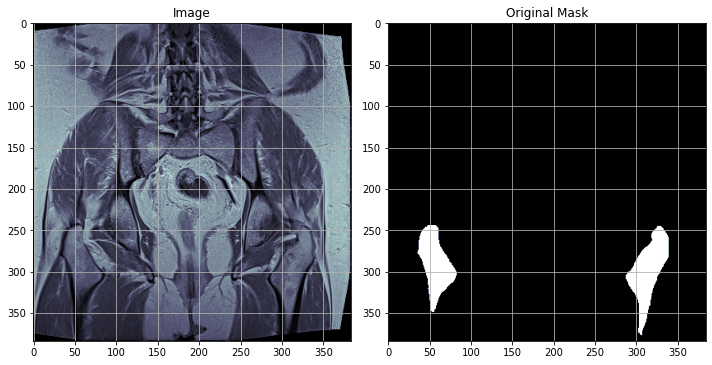

In [ ]:
!pip install matplotlib==3.1.3
ex_img, ex_label, ex_img_dir, ex_label_dir = view_img_label(image_dir, label_dir)
ex_label = np.rot90(ex_label, 3)
ex_label = cv2.flip(ex_label, 1)
print(type(ex_img))
print(f'image shape: {ex_img.shape}')
print(f'label shape: {ex_label.shape}')
print(ex_img[30,40])
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
# plot the original image, its mask, and the predicted mask
ax[0].imshow(ex_img, cmap=plt.cm.bone)
ax[1].imshow(ex_label, cmap=plt.cm.bone)

# set the titles of the subplots
ax[0].set_title("Image")
ax[1].set_title("Original Mask")
ax[0].grid(True)
ax[1].grid(True)

# set the layout of the figure and display it
figure.tight_layout()
figure.show()

resized image shape:  (224, 224)


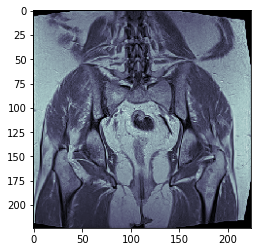

In [ ]:
def resize_img(img, img_stack=1):
  width = config.INPUT_IMAGE_WIDTH #224
  height = config.INPUT_IMAGE_HEIGHT #224
  img_stack_sm = np.zeros((width, height, img_stack)) #empty list of (3, 224, 224)

  if img_stack==1:
    img_stack_sm = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
  else:
    for idx in range(img_stack):
      img2 = img[:, :, idx]
      #print(img2.shape)
      img_sm = cv2.resize(img2, (width, height), interpolation=cv2.INTER_NEAREST)
      #print(img_sm.shape)
      img_stack_sm[:, :, idx] = img_sm
  return img_stack_sm

test_resize_img= resize_img(ex_img)
print("resized image shape: ", test_resize_img.shape)

fig, ax = plt.subplots(num=1)
ax.imshow(test_resize_img, cmap=plt.cm.bone)

##Create FemurData class

In [ ]:
class boneData(Dataset):
  def __init__(self, path, label_path, fileList):
    #self.files = sorted(os.listdir(path))
    #self.labels = sorted(os.listdir(label_path))
    #self.transform = transform
    self.path = path
    self.labelpath = label_path
    self.fileList = fileList

  def __len__(self):
    return len(self.fileList)

  def __getitem__(self, index):
    filename = os.path.join(self.path, self.fileList[index])

    tensor_image = np.load(filename)
    tensor_image = cv2.resize(tensor_image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT))
    image = np.zeros((3, tensor_image.shape[0], tensor_image.shape[1]))
    image[0, :,:] = tensor_image
    image[1, :,:] = tensor_image
    image[2, :,:] = tensor_image
    image = torch.Tensor(image/255)

    label_filename = os.path.join(self.labelpath, self.fileList[index])
    label = np.load(label_filename)
    label = np.rot90(label, 3)
    label = cv2.flip(label, 1)
    label = resize_img(label)
    tensor_label = torch.LongTensor(label)

    return image, tensor_label

In [ ]:
print(image_dir)
print(label_dir)

valset_length = int(len(os.listdir(image_dir)) * 0.1)
print(valset_length)

image_list = sorted(os.listdir(image_dir))
print(image_list)
random.shuffle(image_list)

val_list = sorted(image_list[:valset_length])
train_list = sorted(image_list[valset_length:])

print(val_list)

train_dataset = boneData(image_dir, label_dir, train_list)
test_dataset = boneData(image_dir, label_dir, val_list)

/content/drive/MyDrive/pelvic_project/data/images_2d
/content/drive/MyDrive/pelvic_project/mask/femur_binary_mask_2d
89
['2d_scan_0001.npy', '2d_scan_0002.npy', '2d_scan_0003.npy', '2d_scan_0004.npy', '2d_scan_0005.npy', '2d_scan_0006.npy', '2d_scan_0007.npy', '2d_scan_0008.npy', '2d_scan_0009.npy', '2d_scan_0010.npy', '2d_scan_0011.npy', '2d_scan_0012.npy', '2d_scan_0013.npy', '2d_scan_0014.npy', '2d_scan_0015.npy', '2d_scan_0016.npy', '2d_scan_0017.npy', '2d_scan_0018.npy', '2d_scan_0019.npy', '2d_scan_0020.npy', '2d_scan_0021.npy', '2d_scan_0022.npy', '2d_scan_0023.npy', '2d_scan_0024.npy', '2d_scan_0025.npy', '2d_scan_0026.npy', '2d_scan_0027.npy', '2d_scan_0028.npy', '2d_scan_0029.npy', '2d_scan_0030.npy', '2d_scan_0031.npy', '2d_scan_0032.npy', '2d_scan_0033.npy', '2d_scan_0034.npy', '2d_scan_0035.npy', '2d_scan_0036.npy', '2d_scan_0037.npy', '2d_scan_0038.npy', '2d_scan_0039.npy', '2d_scan_0040.npy', '2d_scan_0041.npy', '2d_scan_0042.npy', '2d_scan_0043.npy', '2d_scan_0044.npy',

In [ ]:
#plt.imshow(train_femur_dataset[24][0])

print(np.unique(train_dataset[20][1])) #resize with keeping new labels
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)
print(len(train_dataset))

print(np.unique(test_dataset[0][1])) #resize with keeping new labels
print(test_dataset[0][0].shape)
print(test_dataset[0][1].shape)
print(len(test_dataset))

[0 1]
torch.Size([3, 224, 224])
torch.Size([224, 224])
809
[0]
torch.Size([3, 224, 224])
torch.Size([224, 224])
89


## Make dataloaders

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

print(len(train_dataloader))

train_x, train_y = next(iter(train_dataloader))

print(f'train_x = shape: {train_x.shape}; type: {train_x.dtype}')
print(f'train_x = min: {train_x.min()}; max: {train_x.max()}')
#print(f'train_y = shape: {train_y.shape}; class: {train_y.unique()}; type: {train_y.dtype}')

val_dataloader = DataLoader(test_dataset, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

val_x, val_y = next(iter(val_dataloader))
print(f'val_x = shape: {val_x.shape}')
print(f'val_y = shape: {val_y.shape}')

dataloaders = {
  'train': train_dataloader,
  'val': val_dataloader
}

print(len(train_dataloader))
print(len(val_dataloader))

41
train_x = shape: torch.Size([20, 3, 224, 224]); type: torch.float32
train_x = min: 0.0; max: 12.612744331359863
val_x = shape: torch.Size([20, 3, 224, 224])
val_y = shape: torch.Size([20, 224, 224])
41
5


In [ ]:
#import torchvision
model = {
    'deeplabv3': torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=2, aux_loss=None),
    'unet': smp.Unet('resnet34', classes=2)
}
model = model[model_type]
#model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=2, aux_loss=None)
if (not(new_training)): # if training is unnecessary
  #model.load_state_dict(torch.load(config.MODEL_PATH))
  model = torch.load(config.MODEL_PATH).to(config.DEVICE)
model = model.to(config.DEVICE)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 40.6MB/s]
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 50.7MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
if (new_training):
  optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  loss_function = nn.CrossEntropyLoss()

  # calculate steps per epoch for training and test set
  trainSteps = len(train_dataset) // config.BATCH_SIZE
  testSteps = len(test_dataset) // config.BATCH_SIZE

  # initialize a dictionary to store training history
  H = {"train_loss": [], "test_loss": []}

  print(trainSteps)

40


In [ ]:
if (new_training):
  print("[INFO] training the network...")
  startTime = time.time()
  for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dataloader):
      # send the input to the device
      (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
      # perform a forward pass and calculate the training loss
      pred = model(x)
      if model_type == 'deeplabv3':
        pred = pred['out']
      #print(pred.shape)
      loss = loss_function(pred, y)
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # add the loss to the total training loss so far
      totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
      # set the model in evaluation mode
      model.eval()
      # loop over the validation set
      for (x, y) in val_dataloader:
        # send the input to the device
        (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
        # make the predictions and calculate the validation loss
        pred = model(x)
        if model_type == 'deeplabv3':
          pred = pred['out']
        totalTestLoss += loss_function(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
      avgTrainLoss, avgTestLoss))
  # display the total time needed to perform the training
  endTime = time.time()
  print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  3%|▎         | 1/30 [03:38<1:45:49, 218.95s/it]

[INFO] EPOCH: 1/30
Train loss: 0.778585, Test loss: 0.6917


  7%|▋         | 2/30 [06:08<1:23:03, 177.97s/it]

[INFO] EPOCH: 2/30
Train loss: 0.305369, Test loss: 0.2914


 10%|█         | 3/30 [08:37<1:14:09, 164.81s/it]

[INFO] EPOCH: 3/30
Train loss: 0.206779, Test loss: 0.2193


 13%|█▎        | 4/30 [11:06<1:08:44, 158.63s/it]

[INFO] EPOCH: 4/30
Train loss: 0.166307, Test loss: 0.1847


 17%|█▋        | 5/30 [13:35<1:04:40, 155.22s/it]

[INFO] EPOCH: 5/30
Train loss: 0.144339, Test loss: 0.1816


 20%|██        | 6/30 [16:04<1:01:15, 153.15s/it]

[INFO] EPOCH: 6/30
Train loss: 0.128538, Test loss: 0.1476


 23%|██▎       | 7/30 [18:34<58:12, 151.86s/it]  

[INFO] EPOCH: 7/30
Train loss: 0.114659, Test loss: 0.1718


 27%|██▋       | 8/30 [21:03<55:22, 151.01s/it]

[INFO] EPOCH: 8/30
Train loss: 0.103530, Test loss: 0.1291


 30%|███       | 9/30 [23:32<52:39, 150.44s/it]

[INFO] EPOCH: 9/30
Train loss: 0.093483, Test loss: 0.1100


 33%|███▎      | 10/30 [26:01<50:01, 150.06s/it]

[INFO] EPOCH: 10/30
Train loss: 0.085156, Test loss: 0.1088


 37%|███▋      | 11/30 [28:30<47:26, 149.79s/it]

[INFO] EPOCH: 11/30
Train loss: 0.078119, Test loss: 0.0928


 40%|████      | 12/30 [30:59<44:52, 149.59s/it]

[INFO] EPOCH: 12/30
Train loss: 0.071978, Test loss: 0.0911


 43%|████▎     | 13/30 [33:29<42:20, 149.47s/it]

[INFO] EPOCH: 13/30
Train loss: 0.066732, Test loss: 0.0862


 47%|████▋     | 14/30 [35:58<39:49, 149.37s/it]

[INFO] EPOCH: 14/30
Train loss: 0.061827, Test loss: 0.0854


 50%|█████     | 15/30 [38:27<37:19, 149.31s/it]

[INFO] EPOCH: 15/30
Train loss: 0.058123, Test loss: 0.0745


 53%|█████▎    | 16/30 [40:56<34:49, 149.27s/it]

[INFO] EPOCH: 16/30
Train loss: 0.053975, Test loss: 0.0742


 57%|█████▋    | 17/30 [43:25<32:20, 149.23s/it]

[INFO] EPOCH: 17/30
Train loss: 0.050885, Test loss: 0.0803


 60%|██████    | 18/30 [45:54<29:50, 149.23s/it]

[INFO] EPOCH: 18/30
Train loss: 0.047654, Test loss: 0.0601


 63%|██████▎   | 19/30 [48:24<27:21, 149.21s/it]

[INFO] EPOCH: 19/30
Train loss: 0.044671, Test loss: 0.0645


 67%|██████▋   | 20/30 [50:53<24:52, 149.21s/it]

[INFO] EPOCH: 20/30
Train loss: 0.042184, Test loss: 0.0544


 70%|███████   | 21/30 [53:22<22:22, 149.18s/it]

[INFO] EPOCH: 21/30
Train loss: 0.039842, Test loss: 0.0543


 73%|███████▎  | 22/30 [55:51<19:53, 149.16s/it]

[INFO] EPOCH: 22/30
Train loss: 0.037564, Test loss: 0.0527


 77%|███████▋  | 23/30 [58:20<17:24, 149.16s/it]

[INFO] EPOCH: 23/30
Train loss: 0.035547, Test loss: 0.0529


 80%|████████  | 24/30 [1:00:49<14:55, 149.18s/it]

[INFO] EPOCH: 24/30
Train loss: 0.033769, Test loss: 0.0482


 83%|████████▎ | 25/30 [1:03:19<12:25, 149.16s/it]

[INFO] EPOCH: 25/30
Train loss: 0.031823, Test loss: 0.0526


 87%|████████▋ | 26/30 [1:05:48<09:56, 149.17s/it]

[INFO] EPOCH: 26/30
Train loss: 0.030470, Test loss: 0.0487


 90%|█████████ | 27/30 [1:08:17<07:27, 149.17s/it]

[INFO] EPOCH: 27/30
Train loss: 0.029094, Test loss: 0.0498


 93%|█████████▎| 28/30 [1:10:46<04:58, 149.16s/it]

[INFO] EPOCH: 28/30
Train loss: 0.027680, Test loss: 0.0475


 97%|█████████▋| 29/30 [1:13:15<02:29, 149.16s/it]

[INFO] EPOCH: 29/30
Train loss: 0.026606, Test loss: 0.0437


100%|██████████| 30/30 [1:15:44<00:00, 151.50s/it]

[INFO] EPOCH: 30/30
Train loss: 0.025235, Test loss: 0.0427
[INFO] total time taken to train the model: 4544.87s


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


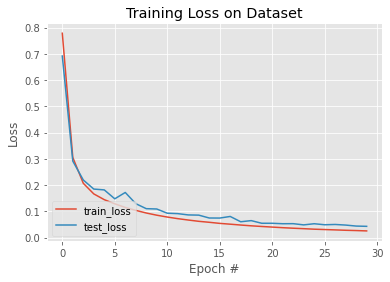

In [ ]:
!pip install matplotlib==3.1.3
if (new_training):
  # plot the training loss
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H["train_loss"], label="train_loss")
  plt.plot(H["test_loss"], label="test_loss")
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig(config.PLOT_PATH)
  # serialize the model to disk
  torch.save(model, config.MODEL_PATH)

In [ ]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage, cmap=plt.cm.bone)
	ax[1].imshow(origMask, cmap=plt.cm.bone)
	ax[2].imshow(predMask, cmap=plt.cm.bone)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

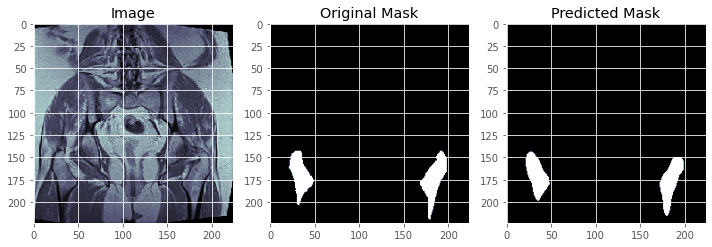

In [ ]:
from skimage import io
from skimage import color
from skimage import segmentation

with torch.no_grad():
  model.eval()
  image = np.load(ex_img_dir)
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.astype("float32") / 255.0
  image = cv2.resize(image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
  orig = image.copy()

  gtMask = np.load(ex_label_dir)
  gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
  gtMask = np.rot90(gtMask, 3)
  gtMask = cv2.flip(gtMask, 1)
  gt_Mask_t = torch.tensor(gtMask)

  temp = np.zeros((3, image.shape[0], image.shape[1]))
  temp[0, :, :] = image
  temp[1,:,:]=image
  temp[2,:,:]=image
  #image = np.transpose(image, (2, 0, 1))
  image = np.expand_dims(temp, 0)
  image = torch.Tensor(image).to(config.DEVICE)
  
  predMask = model(image)
  if model_type == 'deeplabv3':
    predMask = predMask['out']
  predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
  #print(predMask.shape)
  #predMask_RGB = IntToRGB(predMask)

  #y_true, y_pred = onehot(gtMask, predMask)
  #dice_score = dice_coef_multilabel(y_true, y_pred, config.NUM_CLASS)
  #print(f'For original mask and predicted mask {dice_score}')

  prepare_plot(orig, gtMask, predMask)

In [ ]:
def onehot(mask, pred):
  y_true = F.one_hot(torch.LongTensor(mask)).numpy()
  y_pred = F.one_hot(pred, num_classes=2).numpy() 
  return y_true, y_pred

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,index], y_pred[:,:,index])
    return dice/numLabels # taking average

In [ ]:
def make_predictions(model, imagePath, labelPath, showPlot=True):
	# set model to evaluation mode
  model.eval()
	# turn off gradient tracking
  with torch.no_grad():

    image = np.load(imagePath)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0
    image = cv2.resize(image, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
    orig = image.copy()

    groundTruthPath = labelPath
    gtMask = np.load(groundTruthPath)
    gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
    gtMask = np.rot90(gtMask, 3)
    gtMask = cv2.flip(gtMask, 1)
    gt_Mask_t = torch.tensor(gtMask)
 
    temp = np.zeros((3, image.shape[0], image.shape[1]))
    temp[0, :, :] = image
    temp[1,:,:]=image
    temp[2,:,:]=image
    image = np.expand_dims(temp, 0)
    image = torch.Tensor(image).to(config.DEVICE)
    predMask = model(image)
    if model_type == 'deeplabv3':
          predMask = predMask['out']
    predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
  
    y_true, y_pred = gtMask, predMask.numpy()
    #print(y_true.shape)
    dice_score = dice_coef(y_true, y_pred)

    #jaccard = jaccard_index(gt_Mask_t, predMask_np)
		# prepare a plot for visualization
    if (showPlot):
      print("dice_score = ", dice_score)
      prepare_plot(orig, gtMask, predMask)
    return dice_score

[INFO] loading up test image paths...
2d_scan_0321.npy
[INFO] load up model...
dice_score =  0.9467766136890324
dice_score =  0.928649837956464
dice_score =  0.9142506532558574
dice_score =  0.7645429688998658
dice_score =  0.906605923969538
dice_score =  0.8977626763590293
dice_score =  0.8977626763590293
dice_score =  0.9270482615512544
dice_score =  0.9374104186617095
dice_score =  0.9306536315289945
[0.9467766136890324, 0.928649837956464, 0.9142506532558574, 0.7645429688998658, 0.906605923969538, 0.8977626763590293, 0.8977626763590293, 0.9270482615512544, 0.9374104186617095, 0.9306536315289945]


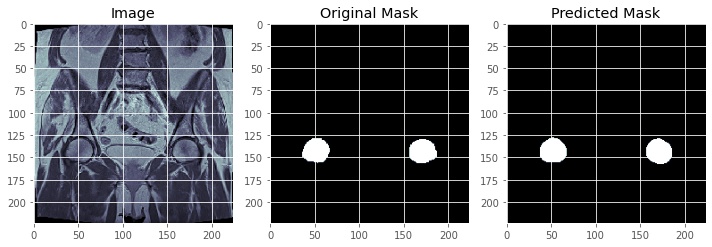

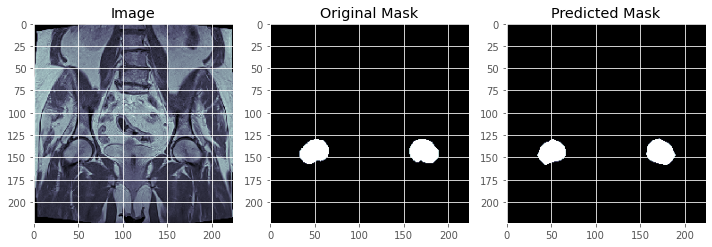

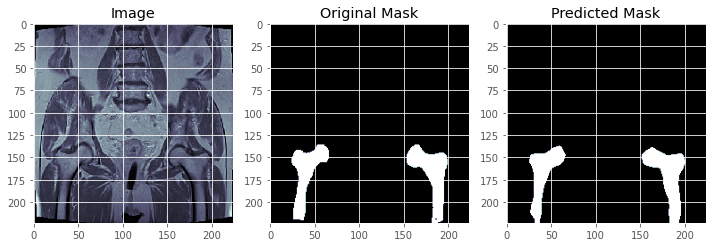

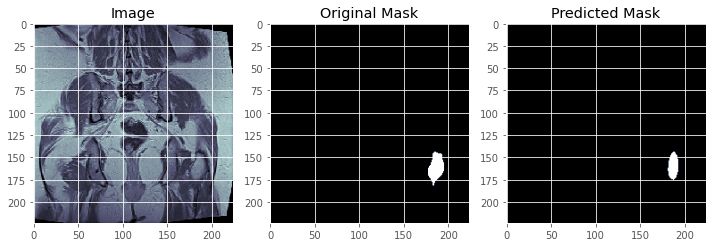

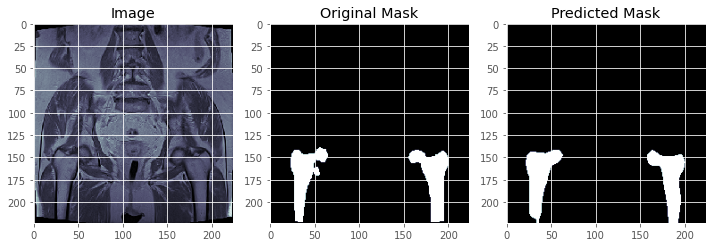

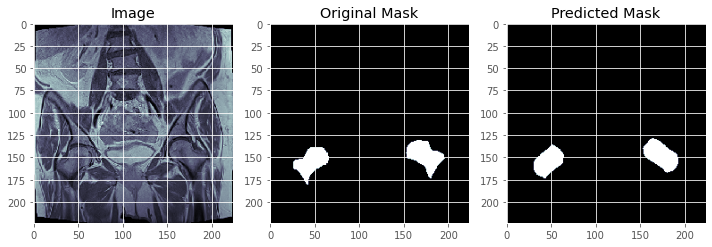

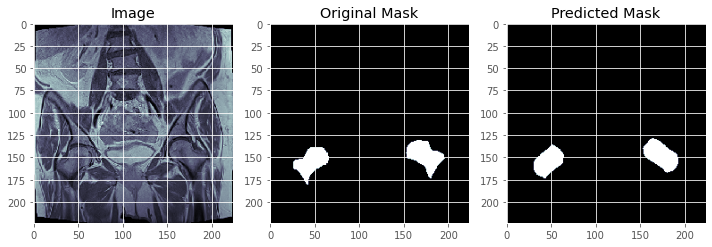

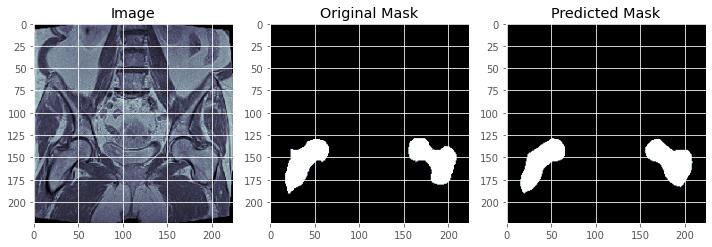

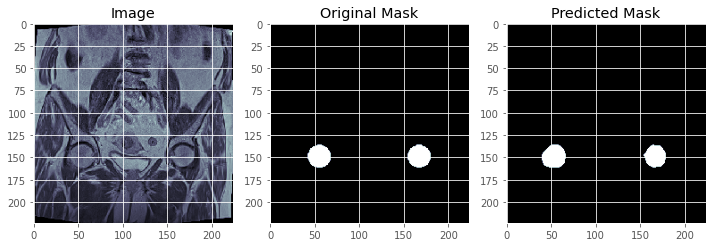

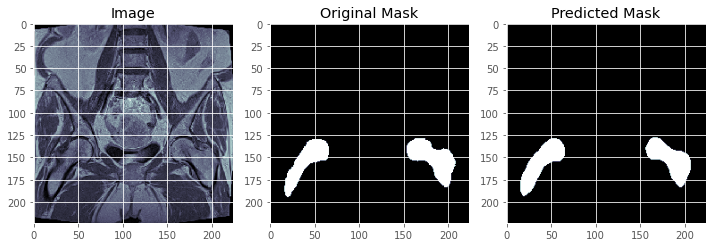

In [ ]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
#imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = []
count = 0
while (count !=10):
  temp = np.random.choice(sorted(os.listdir(image_dir)), size=1)[0]
  scan = os.path.join(config.LABEL_DIR, temp)
  scan = np.load(scan)
  if (len(np.unique(scan))!=1):
    imagePaths.append(temp)
    count +=1
# load our model from disk and flash it to the current device
print(imagePaths[0])
print("[INFO] load up model...")
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
dice_score_list = []
for path in imagePaths:
	# make predictions and visualize the results
  temp = path
  path = os.path.join(image_dir, temp)
  label_path = os.path.join(label_dir, temp)
  dice_score= make_predictions(model, path, label_path)
  dice_score_list.append(dice_score)

print(dice_score_list)

Median of dice score:  0.8854760885152241
25th percentile of dice score :  0.8188671156823796
75th percentile of dice score :  0.9126213626166462


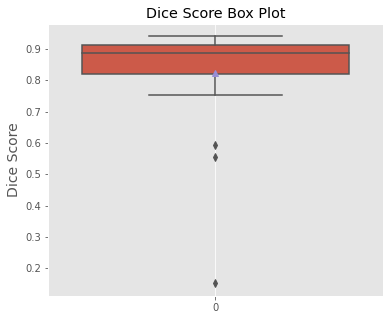

In [ ]:
#Make box plots using the dice score of all the test results
imagePaths = val_list
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over all the test images
dice_score_list = []

for path in imagePaths:
	# make predictions and visualize the results
  temp = path
  path = os.path.join(image_dir, temp)
  label_path = os.path.join(label_dir, temp)
  if len(np.unique(np.load(label_path))) != 1:
    score = make_predictions(model, path, label_path, showPlot=False)
    dice_score_list.append(score)

plt.figure(figsize=(6,5))
sns.boxplot(data=dice_score_list, showmeans=True)
plt.title("Dice Score Box Plot")
plt.ylabel("Dice Score", size=14)
plt.grid()
median = np.median(dice_score_list)
#plt.text(75, 0.07, str(median), fontsize=14)
plt.savefig(config.BOXPLOT_PATH)

print("Median of dice score: ", np.median(dice_score_list))
print("25th percentile of dice score : ",
       np.percentile(dice_score_list, 25))
print("75th percentile of dice score : ",
       np.percentile(dice_score_list, 75))